In [1]:
!pip install tslearn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

from sklearn.metrics import adjusted_mutual_info_score as ami

from tqdm.notebook import tqdm

sys.version

'3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]'

In [2]:
%load_ext autoreload
%autoreload 2

# Get S&P 500 Ticker list

In [3]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df_ticker = table[0]

In [4]:
df_ticker.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [5]:
df_ticker.shape

(503, 8)

In [8]:
df_ticker.to_csv("sp500_ticker_sector.csv",index=False)

# Scrape daily stock data for 503 tickers

In [9]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2022, 11, 30)

In [10]:
tickers = list(df_ticker["Symbol"])
tickers[:10]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADM', 'ADBE', 'ADP', 'AES', 'AFL']

In [11]:
stock_prices = yf.download(tickers, start=start, end=end)

[*********************100%%**********************]  503 of 503 completed


5 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 00:00:00 -> 2022-11-30 00:00:00)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['GEHC', 'KVUE', 'VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1420088400, endDate = 1669784400")


In [12]:
stock_prices.head()

Adj Close                                        \
                             A        AAL       AAPL       ABBV ABNB   
Date                                                                   
2015-01-02 00:00:00  37.675808  51.079910  24.498686  45.155636  NaN   
2015-01-05 00:00:00  36.969856  51.051483  23.808516  44.305843  NaN   
2015-01-06 00:00:00  36.393936  50.255585  23.810753  44.086544  NaN   
2015-01-07 00:00:00  36.876953  50.227150  24.144629  45.868374  NaN   
2015-01-08 00:00:00  37.982342  50.843044  25.072327  46.348091  NaN   

                                                                            \
                           ABT       ACGL        ACN       ADBE        ADI   
Date                                                                         
2015-01-02 00:00:00  37.849297  19.496668  76.523422  72.339996  46.066822   
2015-01-05 00:00:00  37.857731  19.379999  75.231377  71.980003  45.229088   
2015-01-06 00:00:00  37.427799  19.423332  74.688713  70.529999  44.167408   
2015-01-07 00:00:00  37.731266  19.536667  76.256401  71.110001  44.631889   
2015-01-08 00:00:00  38.506805  19.876667  77.419235  72.919998  45.419857   

                     ...   Volume                                       \
                     ...     WYNN      XEL       XOM     XRAY      XYL   
Date                 ...                                                 
2015-01-02 00:00:00  ...  2228900  2534900  10220400  1825800   605900   
2015-01-05 00:00:00  ...  1695100  3107200  18502400  1469800  1369900   
2015-01-06 00:00:00  ...  1975800  4749600  16670700  1988400  1333200   
2015-01-07 00:00:00  ...  1472000  2833400  13590700   959800  1038600   
2015-01-08 00:00:00  ...  1676600  2516800  15487500  1409500   821800   

                                                                 
                         YUM      ZBH    ZBRA     ZION      ZTS  
Date                                                             
2015-01-02 00:00:00  2283466   936579  411800  2298700  1784200  
2015-01-05 00:00:00  4418651  2223873  420300  5326000  3112100  
2015-01-06 00:00:00  5004401  1835563  527500  9086500  3977200  
2015-01-07 00:00:00  4554134  1505860  467800  2759900  2481800  
2015-01-08 00:00:00  4258268  1449004  324400  1831500  3121300  

[5 rows x 3018 columns]

In [13]:
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1992 entries, 2015-01-02 00:00:00 to 2022-11-29 00:00:00
Columns: 3018 entries, ('Adj Close', 'A') to ('Volume', 'ZTS')
dtypes: float64(2542), int64(476)
memory usage: 45.9+ MB


In [14]:
stock_prices.to_csv("sp500_stock_prices.csv", index =None)
stock_prices.to_excel("sp500_stock_prices.xlsx")

# Preprocessing The Data

In [15]:
stock_prices.head()

Adj Close                                        \
                             A        AAL       AAPL       ABBV ABNB   
Date                                                                   
2015-01-02 00:00:00  37.675808  51.079910  24.498686  45.155636  NaN   
2015-01-05 00:00:00  36.969856  51.051483  23.808516  44.305843  NaN   
2015-01-06 00:00:00  36.393936  50.255585  23.810753  44.086544  NaN   
2015-01-07 00:00:00  36.876953  50.227150  24.144629  45.868374  NaN   
2015-01-08 00:00:00  37.982342  50.843044  25.072327  46.348091  NaN   

                                                                            \
                           ABT       ACGL        ACN       ADBE        ADI   
Date                                                                         
2015-01-02 00:00:00  37.849297  19.496668  76.523422  72.339996  46.066822   
2015-01-05 00:00:00  37.857731  19.379999  75.231377  71.980003  45.229088   
2015-01-06 00:00:00  37.427799  19.423332  74.688713  70.529999  44.167408   
2015-01-07 00:00:00  37.731266  19.536667  76.256401  71.110001  44.631889   
2015-01-08 00:00:00  38.506805  19.876667  77.419235  72.919998  45.419857   

                     ...   Volume                                       \
                     ...     WYNN      XEL       XOM     XRAY      XYL   
Date                 ...                                                 
2015-01-02 00:00:00  ...  2228900  2534900  10220400  1825800   605900   
2015-01-05 00:00:00  ...  1695100  3107200  18502400  1469800  1369900   
2015-01-06 00:00:00  ...  1975800  4749600  16670700  1988400  1333200   
2015-01-07 00:00:00  ...  1472000  2833400  13590700   959800  1038600   
2015-01-08 00:00:00  ...  1676600  2516800  15487500  1409500   821800   

                                                                 
                         YUM      ZBH    ZBRA     ZION      ZTS  
Date                                                             
2015-01-02 00:00:00  2283466   936579  411800  2298700  1784200  
2015-01-05 00:00:00  4418651  2223873  420300  5326000  3112100  
2015-01-06 00:00:00  5004401  1835563  527500  9086500  3977200  
2015-01-07 00:00:00  4554134  1505860  467800  2759900  2481800  
2015-01-08 00:00:00  4258268  1449004  324400  1831500  3121300  

[5 rows x 3018 columns]

In [16]:
stock_prices.columns

MultiIndex([('Adj Close',    'A'),
            ('Adj Close',  'AAL'),
            ('Adj Close', 'AAPL'),
            ('Adj Close', 'ABBV'),
            ('Adj Close', 'ABNB'),
            ('Adj Close',  'ABT'),
            ('Adj Close', 'ACGL'),
            ('Adj Close',  'ACN'),
            ('Adj Close', 'ADBE'),
            ('Adj Close',  'ADI'),
            ...
            (   'Volume', 'WYNN'),
            (   'Volume',  'XEL'),
            (   'Volume',  'XOM'),
            (   'Volume', 'XRAY'),
            (   'Volume',  'XYL'),
            (   'Volume',  'YUM'),
            (   'Volume',  'ZBH'),
            (   'Volume', 'ZBRA'),
            (   'Volume', 'ZION'),
            (   'Volume',  'ZTS')],
           length=3018)

In [17]:
stock_prices.columns.get_level_values(0)

Index(['Adj Close', 'Adj Close', 'Adj Close', 'Adj Close', 'Adj Close',
       'Adj Close', 'Adj Close', 'Adj Close', 'Adj Close', 'Adj Close',
       ...
       'Volume', 'Volume', 'Volume', 'Volume', 'Volume', 'Volume', 'Volume',
       'Volume', 'Volume', 'Volume'],
      dtype='object', length=3018)

In [18]:
stock_prices.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [19]:
close_prices = stock_prices["Adj Close"]
#close_prices.index = pd.to_datetime(stock_prices[('Date', 'Unnamed: 0_level_1')].values)

close_prices.index

Index([2015-01-02 00:00:00, 2015-01-05 00:00:00, 2015-01-06 00:00:00,
       2015-01-07 00:00:00, 2015-01-08 00:00:00, 2015-01-09 00:00:00,
       2015-01-12 00:00:00, 2015-01-13 00:00:00, 2015-01-14 00:00:00,
       2015-01-15 00:00:00,
       ...
       2022-11-15 00:00:00, 2022-11-16 00:00:00, 2022-11-17 00:00:00,
       2022-11-18 00:00:00, 2022-11-21 00:00:00, 2022-11-22 00:00:00,
       2022-11-23 00:00:00, 2022-11-25 00:00:00, 2022-11-28 00:00:00,
       2022-11-29 00:00:00],
      dtype='object', name='Date', length=1992)

In [20]:
close_prices.reset_index(inplace=True)
close_prices['Date'].dt.normalize()
close_prices.set_index('Date', inplace=True)

In [21]:
close_prices.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2022-11-15', '2022-11-16', '2022-11-17', '2022-11-18',
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-25',
               '2022-11-28', '2022-11-29'],
              dtype='datetime64[ns]', name='Date', length=1992, freq=None)

In [22]:
close_prices.head(5)

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,37.675808,51.079910,24.498686,45.155636,NaN,37.849297,19.496668,76.523422,72.339996,46.066822,...,129.001953,27.616512,62.658432,48.234467,34.026733,44.099751,102.001991,77.430000,23.135227,40.775253
2015-01-05,36.969856,51.051483,23.808516,44.305843,NaN,37.857731,19.379999,75.231377,71.980003,45.229088,...,126.806404,27.303028,60.943996,47.900074,31.908995,43.203732,105.807045,76.339996,22.268373,40.530449
2015-01-06,36.393936,50.255585,23.810753,44.086544,NaN,37.427799,19.423332,74.688713,70.529999,44.167408,...,124.101517,27.448315,60.620003,47.305622,31.721350,42.673447,104.910103,75.790001,21.417871,40.135040
2015-01-07,36.876953,50.227150,24.144629,45.868374,NaN,37.731266,19.536667,76.256401,71.110001,44.631889,...,127.746124,27.685324,61.234253,48.531685,31.971546,44.087555,107.519325,77.720001,21.622316,40.963551
2015-01-08,37.982342,50.843044,25.072327,46.348091,NaN,38.506805,19.876667,77.419235,72.919998,45.419857,...,129.283051,28.006453,62.253448,49.729889,32.212803,44.855579,108.660820,79.379997,21.924906,41.594334


In [23]:
close_prices.shape, close_prices.dropna(axis=1).shape, close_prices.dropna(axis=1).isna().sum().sum()

((1992, 503), (1992, 476), 0)

In [24]:
close_prices.dropna(axis=1, inplace=True); close_prices.shape

C:\Users\Kittipak\AppData\Local\Temp\ipykernel_19388\2022266098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices.dropna(axis=1, inplace=True); close_prices.shape


(1992, 476)

In [25]:
close_prices.index = pd.to_datetime(close_prices.index)
close_prices = close_prices["2018":]
close_prices.shape

(1237, 476)

In [26]:
close_prices.to_csv("sp500_close_prices.csv")

# Sample plots


In [27]:
list(close_prices.columns)[:10]

['A', 'AAL', 'AAPL', 'ABBV', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM']

<AxesSubplot:xlabel='Date'>

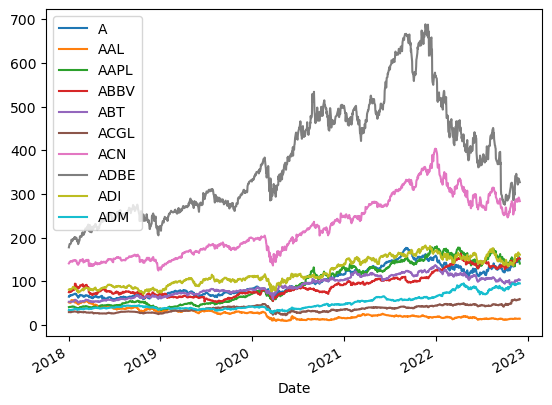

In [28]:
close_prices[list(close_prices.columns)[:10]].plot()

<AxesSubplot:xlabel='Date'>

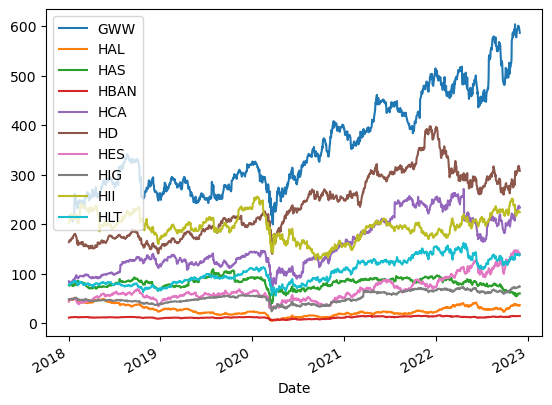

In [29]:
close_prices[list(close_prices.columns)[200:210]].plot()

# Sectors available


In [30]:
df_ticker.head()
# The Global Industry Classification Standard (GICS)

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [31]:
df_ticker["GICS Sector"].value_counts(), df_ticker["GICS Sector"].nunique()

(Industrials               77
 Financials                72
 Health Care               64
 Information Technology    64
 Consumer Discretionary    53
 Consumer Staples          38
 Real Estate               31
 Utilities                 30
 Materials                 29
 Energy                    23
 Communication Services    22
 Name: GICS Sector, dtype: int64,
 11)

In [32]:
close_prices.shape

(1237, 476)

In [33]:
close_prices.T

Date,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,...,2022-11-15,2022-11-16,2022-11-17,2022-11-18,2022-11-21,2022-11-22,2022-11-23,2022-11-25,2022-11-28,2022-11-29
A,64.734840,66.381973,65.884003,66.937386,67.081039,68.728111,67.789665,67.799248,68.689819,68.211014,...,146.961746,146.087921,143.426727,145.164459,144.121811,155.759583,154.260193,155.858887,151.231583,149.881104
AAL,51.647560,51.014027,51.335667,51.316170,50.809345,50.760616,52.417538,54.990662,56.988728,56.511147,...,14.610000,14.090000,13.950000,14.050000,13.850000,13.980000,14.420000,14.500000,13.830000,14.140000
AAPL,40.776527,40.769424,40.958805,41.425129,41.271259,41.266533,41.257065,41.491405,41.919865,41.706810,...,149.402573,148.157883,150.079712,150.647263,147.381210,149.541977,150.428223,147.480789,143.607300,140.570267
ABBV,74.990417,76.163887,75.729546,77.047852,75.813385,76.384895,75.965767,76.188339,77.009567,78.659653,...,147.097549,145.972961,146.251724,148.962219,151.009521,153.585449,153.200974,153.422058,152.278244,152.057190
ABT,53.086952,53.204350,53.114044,53.267559,53.114044,53.204350,53.123077,53.486004,53.386196,53.023266,...,101.117157,101.577942,100.548531,101.832848,101.842651,102.813240,103.940674,104.862236,103.323036,102.940681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,73.644981,73.581810,74.330910,74.764091,74.890465,74.691933,74.502380,74.448196,75.468063,74.845329,...,121.050392,121.688484,120.520287,122.326569,121.747383,122.650528,124.188957,124.780655,124.701767,124.297440
ZBH,115.217323,116.016029,115.848862,117.000481,117.223373,115.338066,113.796387,113.573486,113.397041,113.006989,...,114.244766,113.589783,111.267586,113.222595,113.659248,114.453171,117.112801,118.303673,116.775383,118.095261
ZBRA,103.709999,105.769997,107.860001,109.540001,110.629997,114.019997,114.779999,121.169998,123.150002,123.379997,...,261.589996,258.429993,255.110001,256.100006,257.000000,261.049988,270.660004,271.899994,269.000000,266.820007
ZION,42.626457,42.576012,42.752579,42.769394,42.559204,43.559711,44.013721,44.652687,44.795620,44.476128,...,51.203083,50.007832,48.928249,48.851135,48.976444,49.410206,49.660824,49.882523,48.417377,49.188507


In [35]:
df_ticker.head(5)

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [36]:
df_ticker[df_ticker.Symbol == "A"]["GICS Sector"], df_ticker[df_ticker.Symbol == "A"]["GICS Sector"].values[0]

(10    Health Care
 Name: GICS Sector, dtype: object,
 'Health Care')

In [37]:
get_sector = lambda x: df_ticker[df_ticker.Symbol == x]["GICS Sector"].values[0]

In [38]:
get_sector("MMM")

'Industrials'

In [34]:
# We have a total of 476 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(close_prices.T)
X_train.shape

(476, 1237, 1)

In [39]:
Y_train = np.array([get_sector(ticker) for ticker in close_prices.columns])
Y_train.shape

(476,)

<AxesSubplot:>

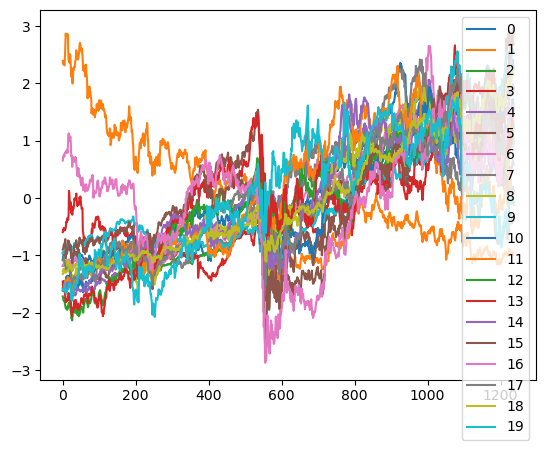

In [40]:
pd.DataFrame(X_train[:20,:,0].T).plot()

# Plot all sectors together

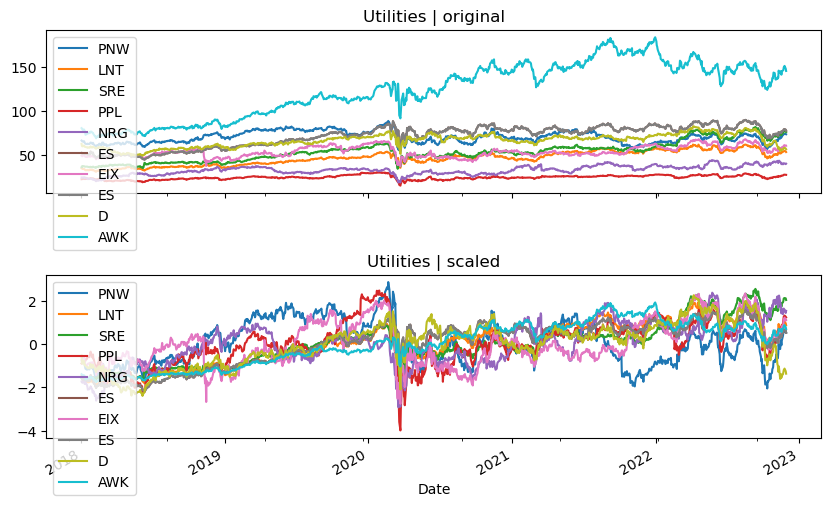

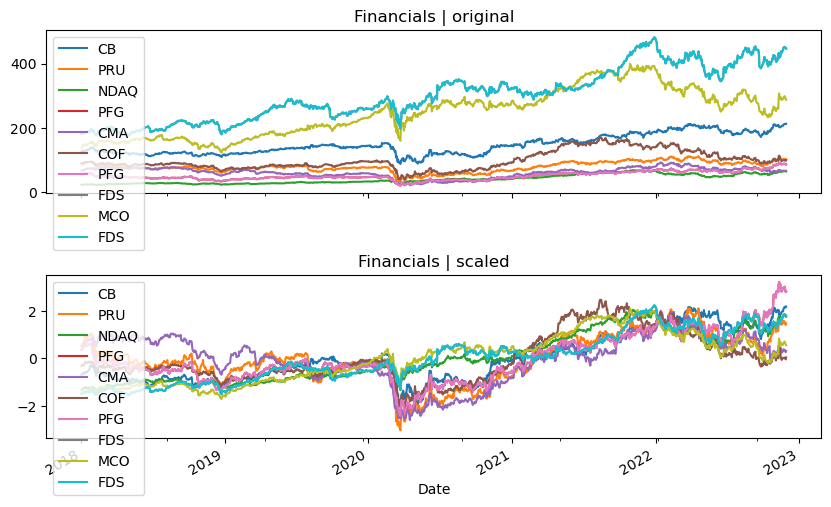

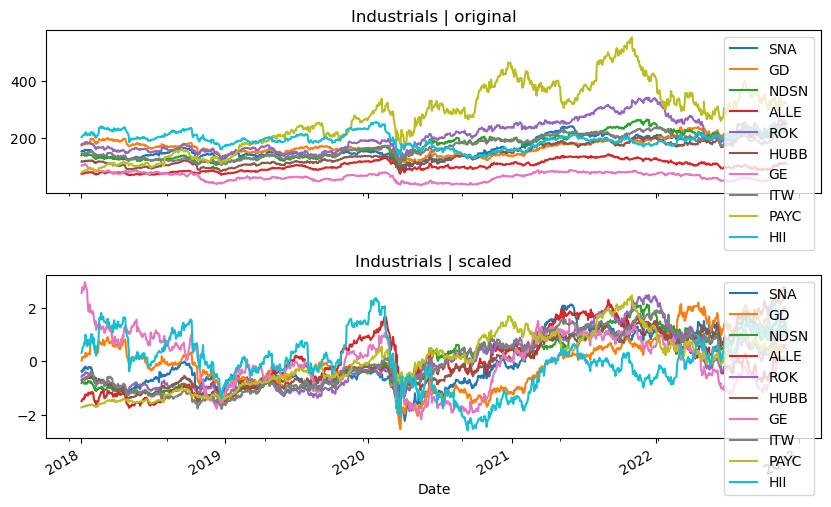

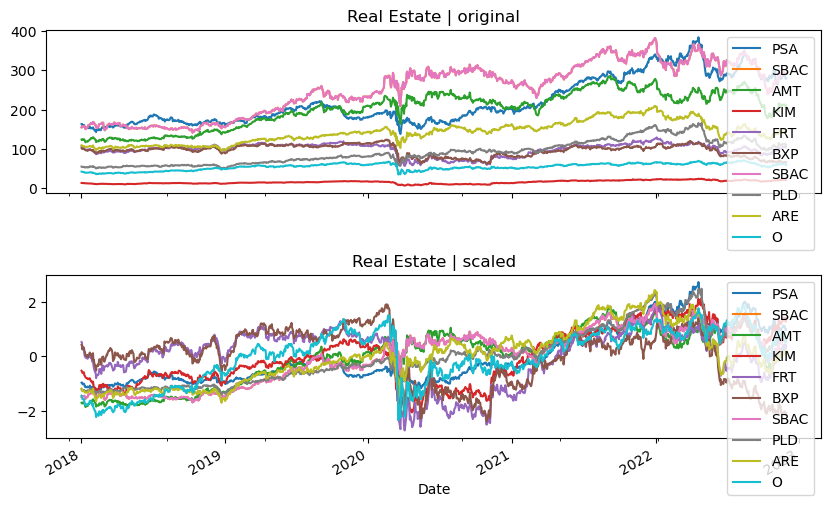

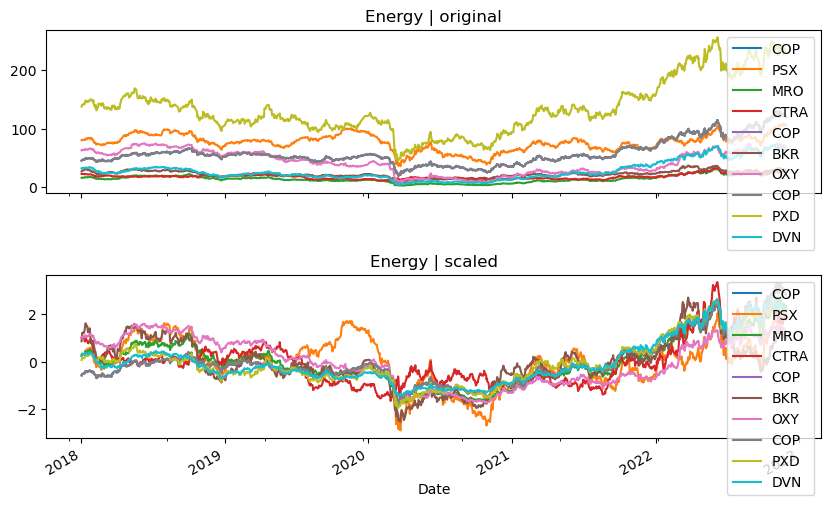

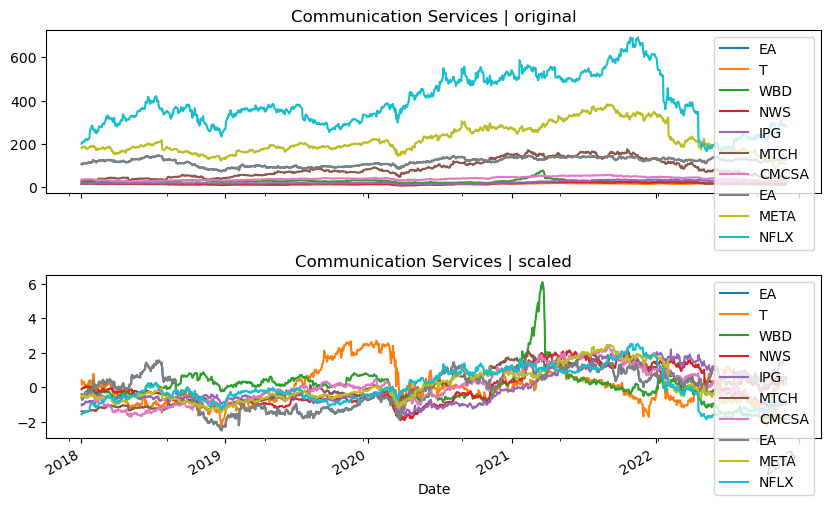

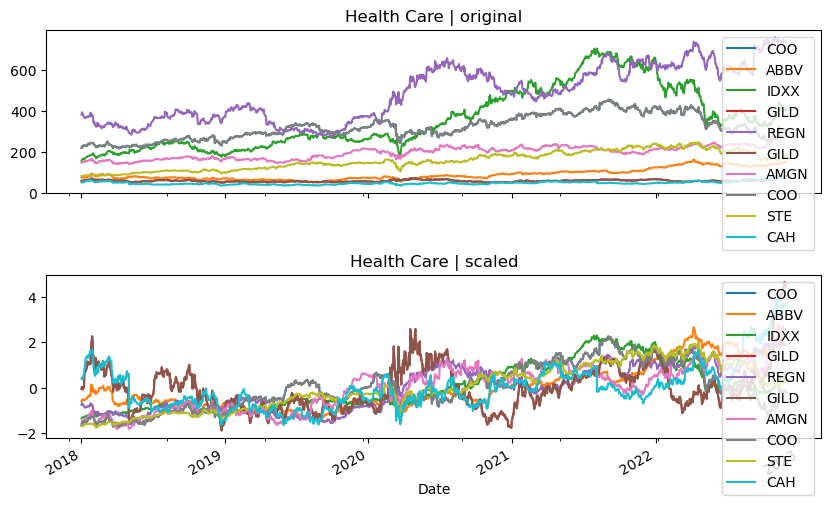

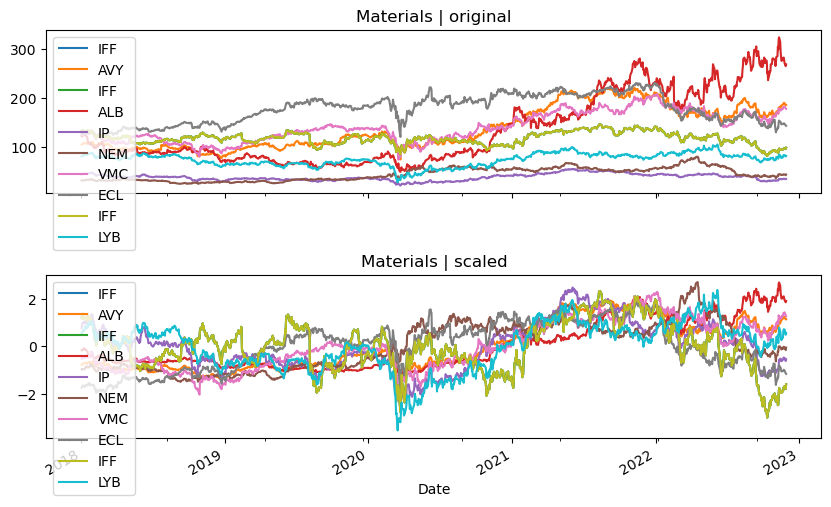

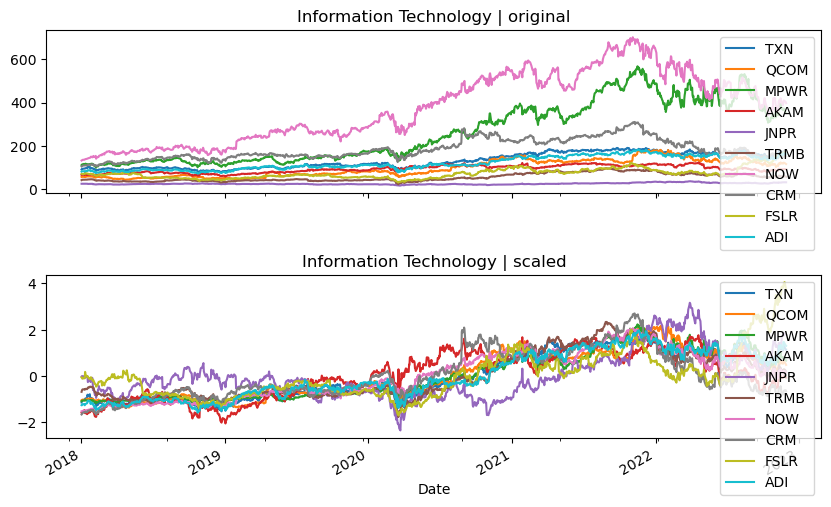

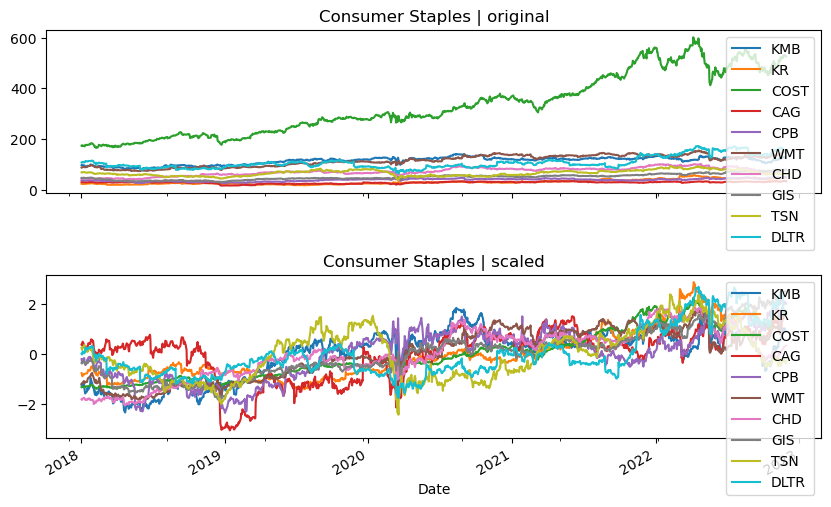

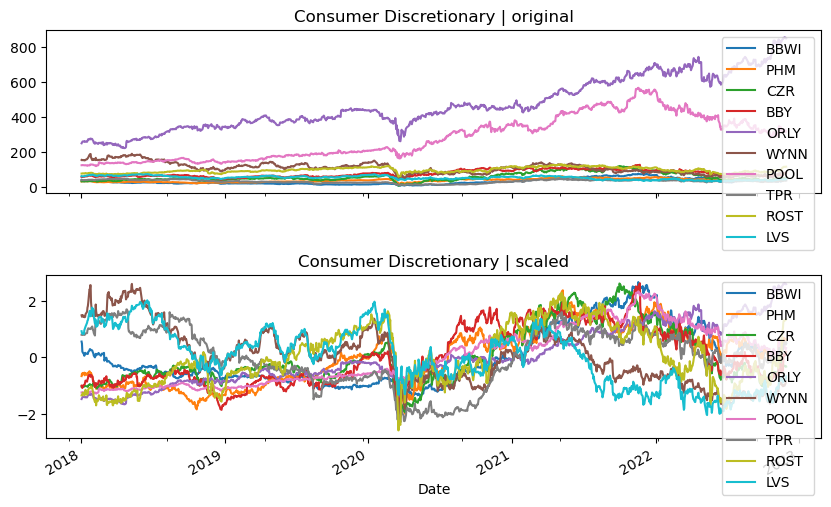

In [41]:
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [12, 5]

for sector in set(Y_train):
    stocks_with_sector = Y_train == sector
    df_subset = close_prices.loc[:, stocks_with_sector]
    sector_cols = df_subset.columns
    scaled_subset = pd.DataFrame(X_train[stocks_with_sector, :, 0].T, columns=sector_cols)
    scaled_subset.index = df_subset.index
    random_columns = np.random.choice(sector_cols, size=min(10, len(scaled_subset)))

    # Increase hspace to add space between subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6), gridspec_kw={'hspace': 0.5})

    df_subset[random_columns].plot(ax=axes[0], title=f"{sector} | original")
    scaled_subset[random_columns].plot(ax=axes[1], title=f"{sector} | scaled")

plt.show()

# Finding the best K

In [44]:
X_train.shape

(476, 1237, 1)

In [45]:
X_train[:10,1000:,].shape

(10, 237, 1)

In [ ]:
import pickle
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import adjusted_mutual_info_score as ami
from tqdm.notebook import tqdm

def ad_clustering(X_train,y_train,k, seed = 69):
    model = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,tol=1e-2,
                          random_state=seed,n_jobs=-1)
    y_pred = model.fit_predict(X_train)
    ami1 = ami(labels_true = y_train, labels_pred = y_pred)
    return (model,y_pred,ami1)

result_dict={}

for k in tqdm(range(5,20)):
    model,y_pred,ami2 = ad_clustering(X_train, Y_train, k)
    result_dict[k] = (model,y_pred,ami2)
    print (f"For k = {k}, ami = {ami2:.5%}")

with open('result_dict.pickle', 'wb') as handle:
    pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
'''
This code is performing time series clustering using the TimeSeriesKMeans algorithm from the tslearn library. Let's break it down:

    1) Importing Libraries:
        - pickle: Used for serializing and deserializing Python objects.
        - TimeSeriesKMeans from tslearn.clustering: A time series clustering algorithm.
        - adjusted_mutual_info_score (renamed as ami) from sklearn.metrics: Used to measure the similarity between the true and predicted cluster assignments.
        - tqdm: A library for displaying progress bars.

    2) Defining Function ad_clustering:
        - Takes as input X_train (time series data), y_train (true labels), k (number of clusters), and an optional parameter seed.
        - Initializes a TimeSeriesKMeans model with specified parameters.
        - Fits the model on the training data (X_train) and predicts cluster labels.
        - Calculates the Adjusted Mutual Information (AMI) score between true labels (y_train) and predicted labels (y_pred).
        - Returns a tuple containing the model, predicted labels, and AMI score.

    3) Loop Over k Values:
        - Iterates over values of k from 5 to 19 using tqdm for progress tracking.
        - Calls the ad_clustering function for each value of k and stores the model, predicted labels, and AMI score in result_dict.
        - Prints the AMI score for each iteration.

    4) Pickling Results:
        - Serializes and saves the result_dict using pickle to a file named 'result_dict.pickle'.

In summary, the code is exploring different values of k for time series clustering, using the TimeSeriesKMeans algorithm, and saving the results, including cluster assignments and AMI scores, for further analysis or comparison.
'''

  0%|          | 0/15 [00:00<?, ?it/s]

Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1428 out of 1428 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 

94.898 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2380 out of 2380 | elapsed:   13.0s finished


32.593 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2380 out of 2380 | elapsed:   14.0s finished


31.434 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2380 out of 2380 | elapsed:   13.3s finished


31.198 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2380 out of 2380 | elapsed:   13.8s finished


31.074 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2380 out of 2380 | elapsed:   13.9s finished


31.027 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2380 out of 2380 | elapsed:   13.9s finished


31.026 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1428 out of 1428 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 

100.973 --> 

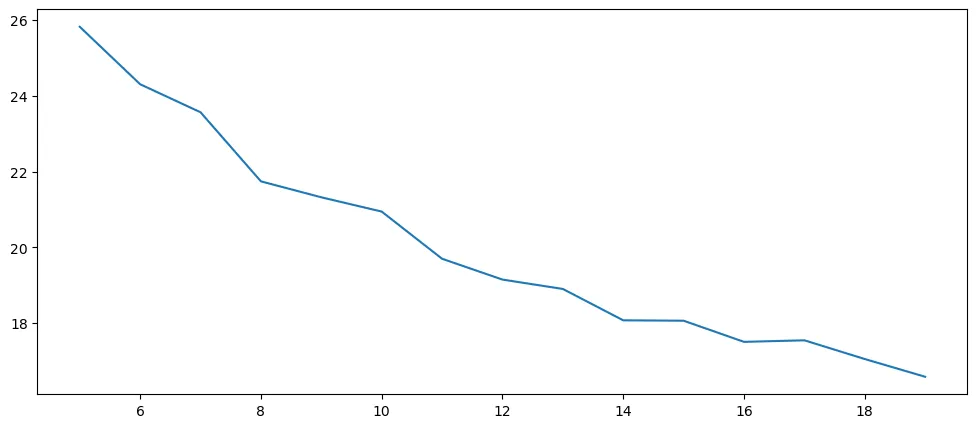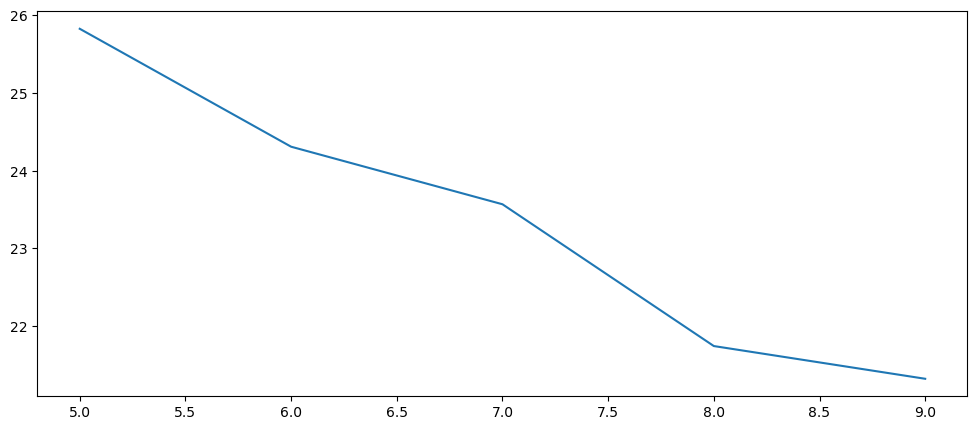